In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
dataset_path = 'data/creditcard.csv'
df = pd.read_csv(dataset_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
dataset_arr = df.to_numpy().astype(np.float64)
X, y = dataset_arr[:, : -1], dataset_arr[:, -1]

In [5]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

In [39]:
n_classes = np.unique(y, axis=0).shape[0]
n_samples = y.shape[0]
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y.astype(np.int8)] = 1
y = y_encoded


In [40]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(199364, 31) (56962, 31) (28481, 31)
(199364, 2) (56962, 2) (28481, 2)


In [41]:
normalizer = StandardScaler ()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [42]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1)[:, None]

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = softmax(dot_product)
    return y_hat

def compute_loss(y_hat, y):
    n = y.size
    return (-1 / n) * np.sum(y * np.log(y_hat))


def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, grad, learning_rate):
    return theta - learning_rate * grad

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis =1) == np.argmax(y, axis =1)).mean()
    return acc

In [43]:
lr = 0.01
epochs = 30
batch_size = 1024
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

In [45]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i, theta)
        #print(y_hat)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.167	Validation loss: 0.165

EPOCH 2:	Training loss: 0.110	Validation loss: 0.108

EPOCH 3:	Training loss: 0.079	Validation loss: 0.078

EPOCH 4:	Training loss: 0.060	Validation loss: 0.059

EPOCH 5:	Training loss: 0.048	Validation loss: 0.048

EPOCH 6:	Training loss: 0.040	Validation loss: 0.040

EPOCH 7:	Training loss: 0.035	Validation loss: 0.034

EPOCH 8:	Training loss: 0.031	Validation loss: 0.030

EPOCH 9:	Training loss: 0.027	Validation loss: 0.027

EPOCH 10:	Training loss: 0.025	Validation loss: 0.025

EPOCH 11:	Training loss: 0.023	Validation loss: 0.023

EPOCH 12:	Training loss: 0.021	Validation loss: 0.021

EPOCH 13:	Training loss: 0.020	Validation loss: 0.019

EPOCH 14:	Training loss: 0.018	Validation loss: 0.018

EPOCH 15:	Training loss: 0.017	Validation loss: 0.017

EPOCH 16:	Training loss: 0.016	Validation loss: 0.016

EPOCH 17:	Training loss: 0.016	Validation loss: 0.015

EPOCH 18:	Training loss: 0.015	Validation loss: 0.015

EPOCH 19:	Training

Text(0.5, 1.0, 'Validation Accuracy')

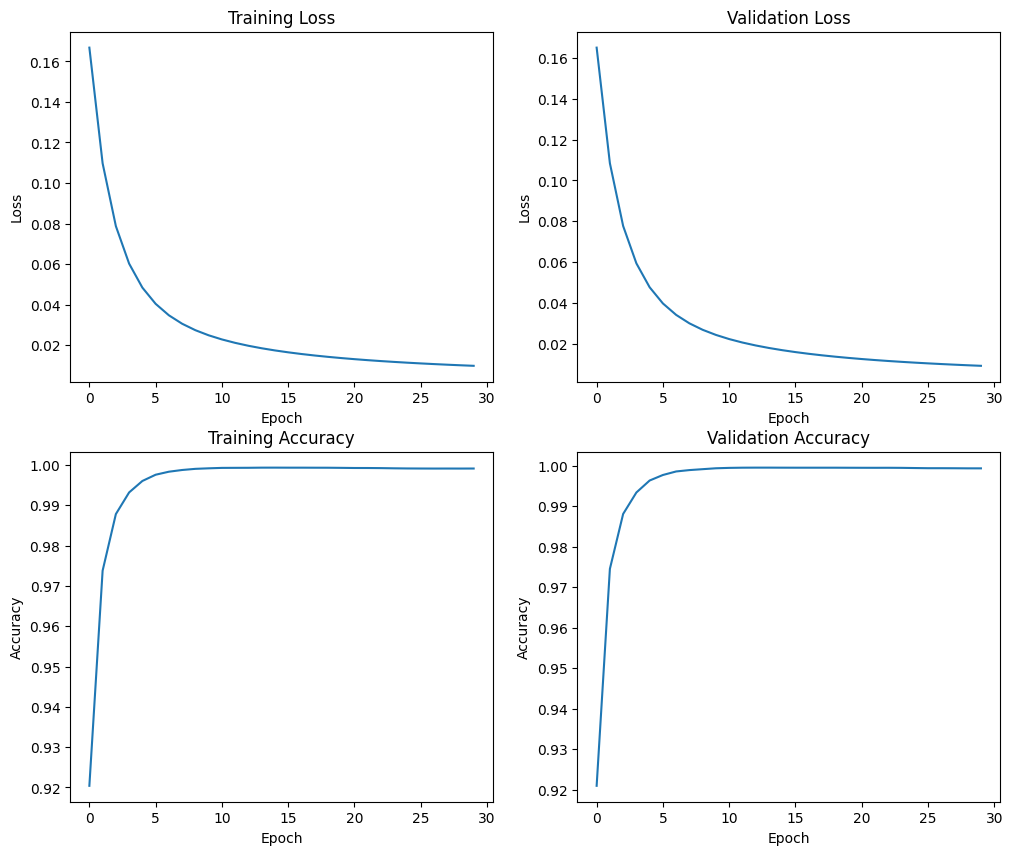

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 1].plot(val_losses)
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 1].plot(val_accs)
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [47]:
val_set_acc = compute_accuracy (X_val , y_val , theta )
test_set_acc = compute_accuracy ( X_test , y_test , theta )
print ('Evaluation on validation and test set :')
print (f'Accuracy : { val_set_acc }')
print (f'Accuracy : { test_set_acc }')

Evaluation on validation and test set :
Accuracy : 0.9992977774656788
Accuracy : 0.9992275552122467


### Twitter Sentiment Analysis

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
dataset_path = 'data\Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df.head()


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\DELL\AppData\Local\Temp\ipykernel_2564\3051009518.py:1: SyntaxWarning: invalid escape sequence '\T'
  dataset_path = 'data\Twitter_Data.csv'


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [50]:
df = df.dropna()


In [51]:
def text_normalize ( text ):
    # Lowercasing
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt [\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Stemming
    stemmer = SnowballStemmer('english')
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


In [57]:
vectorizer = TfidfVectorizer(tokenizer=text_normalize, max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [58]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y.astype(np.int8)] = 1
y = y_encoded


In [59]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(114078, 253) (32594, 253) (16297, 253)
(114078, 3) (32594, 3) (16297, 3)


In [60]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1)[:, None]

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = softmax(dot_product)
    return y_hat

def compute_loss(y_hat, y):
    n = y.size
    return (-1 / n) * np.sum(y * np.log(y_hat))


def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, grad, learning_rate):
    return theta - learning_rate * grad

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis =1) == np.argmax(y, axis =1)).mean()
    return acc

In [61]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i, theta)
        #print(y_hat)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.388	Validation loss: 0.386

EPOCH 2:	Training loss: 0.387	Validation loss: 0.385

EPOCH 3:	Training loss: 0.386	Validation loss: 0.384

EPOCH 4:	Training loss: 0.385	Validation loss: 0.383

EPOCH 5:	Training loss: 0.384	Validation loss: 0.382

EPOCH 6:	Training loss: 0.383	Validation loss: 0.381

EPOCH 7:	Training loss: 0.382	Validation loss: 0.380

EPOCH 8:	Training loss: 0.381	Validation loss: 0.379

EPOCH 9:	Training loss: 0.380	Validation loss: 0.379

EPOCH 10:	Training loss: 0.379	Validation loss: 0.378

EPOCH 11:	Training loss: 0.378	Validation loss: 0.377

EPOCH 12:	Training loss: 0.378	Validation loss: 0.376

EPOCH 13:	Training loss: 0.377	Validation loss: 0.376

EPOCH 14:	Training loss: 0.376	Validation loss: 0.375

EPOCH 15:	Training loss: 0.376	Validation loss: 0.374

EPOCH 16:	Training loss: 0.375	Validation loss: 0.374

EPOCH 17:	Training loss: 0.375	Validation loss: 0.373

EPOCH 18:	Training loss: 0.374	Validation loss: 0.373

EPOCH 19:	Training

Text(0.5, 1.0, 'Validation Accuracy')

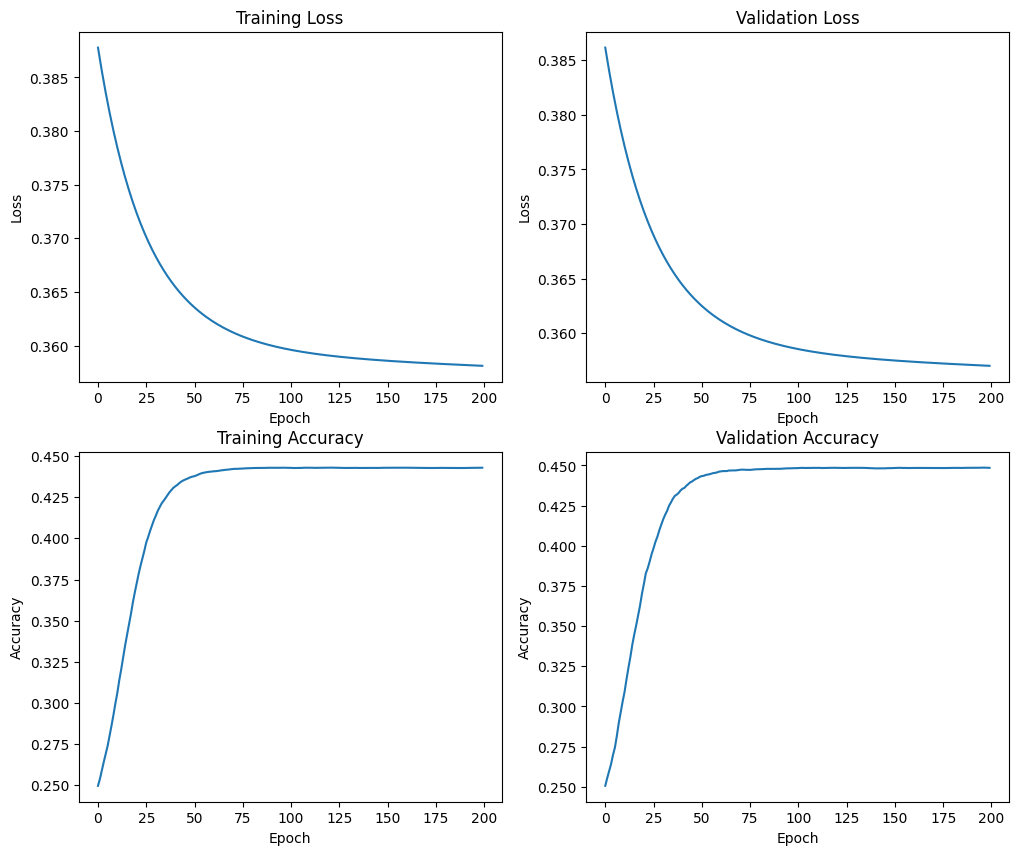

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 1].plot(val_losses)
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 1].plot(val_accs)
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [63]:
val_set_acc = compute_accuracy (X_val , y_val , theta )
test_set_acc = compute_accuracy ( X_test , y_test , theta )
print ('Evaluation on validation and test set :')
print (f'Accuracy : { val_set_acc }')
print (f'Accuracy : { test_set_acc }')

Evaluation on validation and test set :
Accuracy : 0.44854881266490765
Accuracy : 0.44603301221083635


### Exercise


In [67]:
#5. Cho kết quả dự đoán từ mô hình Softmax Regresion trên một mẫu dữ liệu y_hat = (0.4;
#0.15; 0.05; 0.4) và nhãn thực tế y = (1; 0; 0; 0). Giá trị loss cross entropy của mô hình là
#(làm tròn đến hàng thập phân thứ 3):

print(compute_loss(np.array([0.4, 0.15, 0.05, 0.4]), np.array([1, 0, 0, 0])))

0.22907268296853875


In [70]:
#6. Cho bộ giá trị tuyến tính Z = (-1; -2; 3; 2). Sử dụng công thức hàm Softmax, bộ giá trị
#xác suất đầu ra tương ứng là (làm tròn đến hàng thập phân thứ 3):

print(softmax(np.array([[-1, -2, 3, 2]])).round(3))



[[0.013 0.005 0.718 0.264]]


In [ ]:
#8. Cho kết quả dự đoán từ mô hình Softmax Regression y_hat = (0; 1; 3; 2; 0; 2; 1; 2) và kết
#quả thực tế y = (0; 0; 3; 2; 1; 2; 2; 1) (mỗi giá trị trong ngoặc tương ứng với tên class).
#Như vậy, độ chính xác (Accuracy) của mô hình là:

print(compute_accuracy(np.array([[0, 1, 3, 2, 0, 2, 1, 2]]), np.array([[0, 0, 3, 2, 1, 2, 2, 1]]), np.array([[0, 1, 3, 2, 0, 2, 1, 2]])))